In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the number of samples
n_samples = 1000

# Generate the data
data = {
    'satisfaction_level': np.round(np.random.uniform(0, 1, n_samples), 2),
    'last_evaluation': np.round(np.random.uniform(0, 1, n_samples), 2),
    'number_project': np.random.randint(1, 7, n_samples),
    'average_montly_hours': np.random.randint(90, 310, n_samples),
    'time_spend_company': np.random.randint(2, 11, n_samples),
    'Work_accident': np.random.randint(0, 2, n_samples),
    'left': np.random.randint(0, 2, n_samples),
    'promotion_last_5years': np.random.randint(0, 2, n_samples),
    'sales': np.random.choice(['sales', 'accounting', 'hr', 'technical', 'support', 'management', 'IT', 'product_mng', 'marketing', 'RandD'], n_samples),
    'salary': np.random.choice(['low', 'medium', 'high'], n_samples)
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df.head()


## 1. Exploratory Data Analysis (EDA)

To understand what factors contributed most to employee turnover, we can analyze the correlation and visualize the relationships between the features and the target variable.

In [ ]:
# Display basic statistics of the data
df.describe(include='all')

In [ ]:
# Check for missing values
df.isnull().sum()

In [ ]:
# Correlation matrix
cols = df.columns 
df1 = df[cols[:-2]] 
correlation_matrix = df1.corr().round(2)
print(correlation_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Separate categorical and numerical variables
cols = list(df.columns)
categorical_vars = cols[-2:] #['sales', 'salary']
numerical_vars = df.drop(columns=categorical_vars).columns

# Boxplots to visualize the relationship between 'left' and numeric features
for column in numerical_vars:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='left', y=column, data=df)
    plt.title(f'Relationship between {column} and Employee Turnover')
    plt.show()

### Distribution Plot 


In [ ]:
# Distribution of Numerical Features and turnover
for feature in numerical_vars:
    plt.figure(figsize=(10, 5))
    # sns.histplot(df[feature], kde=True)
    sns.histplot(x=feature, hue='left',data=df,  kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show() 

In [ ]:
# # Plot categorical features
# for feature in categorical_vars:
#     plt.figure(figsize=(10, 5))
#     sns.countplot(x=feature, data=df)
#     plt.title(f'Distribution of {feature}')
#     plt.show()

# Plot categorical features and turnover
for feature in categorical_vars:
    plt.figure(figsize=(10, 5))
    sns.histplot(x=feature, hue='left',data=df)
    plt.title(f'Distribution of {feature}')
    plt.show() 
       

In [ ]:
# Plot turnover rate
plt.figure(figsize=(10, 5))
sns.countplot(x='left', data=df)
plt.title('Turnover Rate')
plt.show()

## 2. Perform K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans

# Filter employees who left
df_left = df[df['left'] == 1]

# Select features for clustering
X = df_left[['satisfaction_level', 'last_evaluation']]

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
df_left['cluster'] = kmeans.fit_predict(X)


# Visualize the clusters
# plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_left, x='satisfaction_level', y='last_evaluation', hue='cluster', palette='viridis')
plt.title('K-Means Clustering of Employees Who Left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.show()

# Visualize the clusters
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue='cluster', data=df_left, palette='Set1')
# plt.title('K-Means Clustering of Employees Who Left')
# plt.show()

## 3. Handle Class Imbalance Using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print('All packages for handling Class Imbalance imported successfully!')

In [54]:

df_categorical = df[categorical_vars]
df_numerical = df[numerical_vars]

# Apply get_dummies() to categorical variables. One-hot encode categorical variables
df_categorical_dummies = pd.get_dummies(df_categorical)

# Combine categorical and numerical variables
df_combined = pd.concat([df_numerical, df_categorical_dummies], axis=1)

# Separate features and target variable
X = df_combined.drop('left', axis=1)
y = df_combined['left']

# Apply SMOTE
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the balance of the new dataset
print("Before applying stratified split")
print(y_resampled.value_counts())


Before applying stratified split
left
1    503
0    503
Name: count, dtype: int64


### Do the stratified split of the dataset to train and test in the ratio 80:20 with random_state=123

In [61]:

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the balance of the new dataset
print("After applying stratified split")
print(y_train_resampled.value_counts())

# Apply StandardScaler to the training and test sets
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

After applying stratified split
left
0    402
1    402
Name: count, dtype: int64


## 4. Perform 5-Fold Cross-Validation and Model Evaluation

We'll train and evaluate Logistic Regression and Random Forest models using 5-fold cross-validation.

In [66]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_auc_score

print('All packages for  5-fold cross-validatione imported successfully!')

All packages for  5-fold cross-validatione imported successfully!


In [74]:
# Initialize models 
log_reg = LogisticRegression(max_iter=10000,random_state=123)
rf = RandomForestClassifier(random_state=0)
gb_classifier = GradientBoostingClassifier(random_state=0)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# # Define scoring metric
scoring = make_scorer(roc_auc_score)

# Perform 5-fold cross-validation for Logistic Regression
log_reg_scores = cross_val_score(log_reg, X_resampled, y_resampled, cv=cv, scoring=scoring)
print("Logistic Regression AUC Scores:", log_reg_scores)

# Perform 5-fold cross-validation for Logistic Regression
print("5-fold cross-validation with stratified split")
# Perform 5-fold cross-validation for Logistic Regression
log_reg_scores_2 = cross_val_score(log_reg, X_train_resampled, y_train_resampled, cv=cv, scoring=scoring)
print("Logistic Regression AUC Scores:", log_reg_scores_2)

Logistic Regression AUC Scores: [0.46534653 0.47772277 0.50277228 0.46272277 0.50757426]
5-fold cross-validation with stratified split
Logistic Regression AUC Scores: [0.51589506 0.48410494 0.50949074 0.5404321  0.44375   ]


In [77]:
# Initialize lists to store classification reports
log_reg_reports = []
rf_reports = []
# Perform 5-fold cross-validation for Logistic Regression
for train_index, test_index in cv.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    log_reg_reports.append(report)

def aggregate_reports(reports):
    """Aggregate multiple classification reports into a single report."""
    aggregated_report = {}
    for key in reports[0].keys():
        if isinstance(reports[0][key], dict):
            aggregated_report[key] = {metric: np.mean([r[key][metric] for r in reports]) for metric in reports[0][key].keys()}
        else:
            aggregated_report[key] = np.mean([r[key] for r in reports])
    return aggregated_report

def plot_classification_report(report, title):
    """Plot the classification report as a heatmap."""
    df_report = pd.DataFrame(report).iloc[:-1, :].T
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_report, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()
    

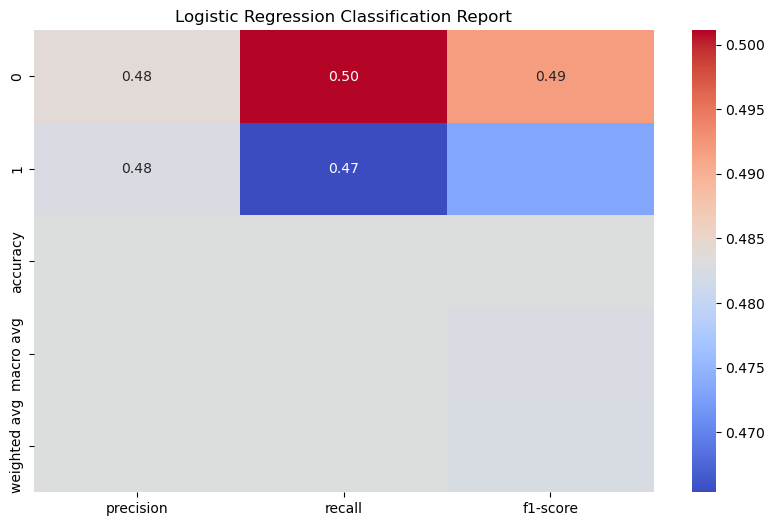

In [79]:
# Aggregate reports
log_reg_aggregated_report = aggregate_reports(log_reg_reports)

# Plot the classification reports
plot_classification_report(log_reg_aggregated_report, 'Logistic Regression Classification Report')
